# Index

1. Propagation
    1. Numerical implementation limitations
        1. Aliasing of fringes in inline holography
2. Resolution analysis
    1. Resolution limited by pixel pitch (magnified by geometry)
    2. Resolution limited by numerical aperture (function of $z$)
    3. Axial resolution
3. Model for calibration based on reconstructed distances and scaling between those distances
4. Lensfree DIH (Gabor)
    1. Focusing of a laser beam to a small spot
    2. Spatial filter calculations for GEM532
    3. Using windows
5. Spatial filter with 3 lenses to get higher beam magnification
6. Damage threshold of sensor

$\newcommand{\cm}{\mbox{cm}}
\newcommand{\mm}{\mbox{mm}}
\newcommand{\NA}{\mbox{NA}}$
# 1. Propagation
[1] 2017 - Review of digital holography reconstruction methods

Rayleigh-Sommerfeld (convolution):
$$h^{RS}_z = \frac{z}{i\lambda}\frac{\exp(ikr)}{r^2},$$
$$r=\sqrt{x^2+y^2+z^2}$$
There is no analytical expression for using in frequency space. 

The Fresnel approximation is suitable when $z^3 \gg \frac{\pi l^4}{64\lambda}$, with $l$ a characteristic dimension of the object.

Fresnel:
$$h^{F}_z = \frac{\exp(ikz)}{i\lambda z}\exp\left(\frac{i\pi(x^2+y^2)}{\lambda z}\right)$$
$$H^{F}_z = \exp(ikz)\exp[-i\pi \lambda z(v_x^2+v_y^2)]$$

Fresnel Diffraction integral:
$$U_z(x,y) = \frac{\exp(ikz)}{i\lambda z}\exp\left(\frac{i\pi}{\lambda z}(x^2+y^2)\right) \mathfrak{F}\left[U_o(x,y)\exp\left(\frac{i\pi}{\lambda z}(x^2+y^2)\right)\right]$$
$$\Delta\xi = \Delta\eta = \frac{\lambda z}{N\Delta_p},$$
at the reconstruction plane. In a numerical implementation, multiply by $\Delta_p^2 $ accounting for the differentials in the integral.

When $z^3 \gg \frac{k}{2}(\xi^2+\eta^2)$ the Fraunhofer approximation is valid (actually, $(\xi^2+\eta^2)$ should be related to the dimensions of the object and not the whole image):
$$U_z(x,y) = \frac{\exp(ikz)}{i\lambda z}\exp\left(\frac{i\pi}{\lambda z}(x^2+y^2)\right) \mathfrak{F}[U_o(x,y)]$$

Angular Spectrum Method ($z\gg \lambda$):
$$H^{AS}_z = \exp \left(ikz\sqrt{1-(\lambda v_x)^2-(\lambda v_y)^2}\right)$$,
si: $\sqrt{v_x^2+v_y^2}<1/\lambda$, si no, $H^{AS}_z = 0$

In a numeric implementation: $\Delta v_x = 1/(M\Delta x)$. Particularly, use $\Delta_p$ when $\Delta x = \Delta y$.

## 1.A Numerical implementation limitations

Rayleigh-Sommerfeld:
$$z_{\min}^{RS} = \sqrt{M^2 + N^2}\Delta_p \sqrt{\left(\frac{\Delta_p}{\lambda}\right)^2-\frac{1}{2}}$$
Fresnel (convolution):
$$z_{\min}^{F} = \sqrt{M^2 + N^2}\Delta_p \frac{\Delta_p}{\lambda}$$
When working with the Fourier transformed space (Fresnel or ASM):
$$z_{\max}^{ASM} = \min(M,N) \frac{\Delta_p^2}{\lambda}$$

If the reconstruction distance $z > z_{\max}$ then the spatial bandwidth gets reduced (using $u=n\Delta_p$ with $-N \leq n < N$):
$$u_{\lim} = \lambda^{-1}\left[\left(\frac{z}{N\Delta_p} \right)^2+1 \right]^{-1/2}\mbox{  or  } \lambda^{-1}\left[\left(\frac{2z}{\mbox{width}} \right)^2+1 \right]^{-1/2}$$

In [1]:
import math
l = 125e-6  # size of object
wavelength = 355e-9
zero_padding = True
M0 = 13264
N0 = 9176
delta_p = 2.2e-6
downsampling = 1
crop_factor = 1
max_z = 96e-2

M0 = 2*M0 if zero_padding else M0
N0 = 2*N0 if zero_padding else N0

Mc = M0 * crop_factor
Nc = N0 * crop_factor
M = Mc / downsampling
N = Nc / downsampling
delta_p = delta_p *downsampling

# Minimum distance for Fresnel approximation
z_min_ap_Fresnel = 10*(math.pi * l**4 / 64 / wavelength)**(1/3)
print("The minimum distance for using Fresnel approx is {:.2f} mm.".format(z_min_ap_Fresnel*1000))
# Minimum distance for Fraunhofer approximation 
z_min_ap_Fraunhofer = 10*(math.pi * l**2 / 4 / wavelength)**(1/3)
print("The minimum distance for using Fraunhofer approx is s {:.2f} mm.".format(z_min_ap_Fraunhofer*1000))

# Limitations of the numerical implementations
# RS
root = math.sqrt(M**2+N**2)
z_min_RS = root * delta_p * math.sqrt((delta_p/wavelength)**2-0.5)
# F
z_min_F = root * delta_p**2 /wavelength
# ASM
z_max_ASM = min(M,N)*delta_p**2 /wavelength
print("The minimum distance to use Rayleigh Sommerfeld is {:.2f} mm, Fresnel is {:.2f} mm and the maximum distances for ASM (or Fresnel in Fourier transformed space) is {:.2f} mm.".format(z_min_RS*1e3,z_min_F*1e3,z_max_ASM*1e3))
# Required upsampling for using ASM at a particular z value
up_required = max_z / min(Mc,Nc)/delta_p**2 *wavelength
print("The minimum upsampling to implement ASM at max_z={:.2f} cm with crop_factor {:.2f} is {:.2f}.".format(max_z*100,crop_factor,up_required))

The minimum distance for using Fresnel approx is 3.23 mm.
The minimum distance for using Fraunhofer approx is s 3257.57 mm.
The minimum distance to use Rayleigh Sommerfeld is 436.92 mm, Fresnel is 439.79 mm and the maximum distances for ASM (or Fresnel in Fourier transformed space) is 250.21 mm.
The minimum upsampling to implement ASM at max_z=96.00 cm with crop_factor 1.00 is 3.84.


For $l=[1\mu m, 10\mu m, 100\mu m]$, the minimum z to use Fresnel should be at least $[4.5\mu m, 97 \mu m, 2 mm]$

The crop_factor reduces the minimum propagation distance of convolution based methods and it reduces the ASM's maximum z.

Enlarging the image (frequency upsampling) $\gamma$ extends the range for ASM:
$$z_{\max}^{ASM} = \gamma \min(M,N) \frac{\Delta_p^2}{\lambda}$$
$$\gamma_{\min} = \frac{z\lambda}{\min(M,N)\Delta_p^2}$$

Beyond this limit, Fresnel should be used.

### 1.A.a Aliasing of fringes in inline holography
2017 - Aliasing, coherence, and resolution in a lensless holographic microscope

If $W$ is the width of the sensor, $L$ is the distance from the sample to the sensor:
$$NA=\sin\theta_{max}=\frac{W/L}{\sqrt{1+(W/L)^2}}$$
To avoid aliasing: $\lambda/ \sin\theta \geq 2p$, $NA\leq\lambda/(2p)$, being $\theta$ the incidence angle and $p$ the pixel size. Worst case without aliasing is $\theta=\theta_{max}$. Using both equations:
$$L \geq W\sqrt{\left(\frac{2p}{\lambda}\right)^2-1}.$$
Besides, the resolution given by the $NA$ is : $r=\frac{\lambda}{2NA}$. If $L$ needs to be larger than a particular value to avoid aliasing, then NA will be less than a maximum value, so that resolution will be:
$$r\geq p.$$
But, if we consider the visibility of the fringes compared to the SNR $S$, and $p\gg\lambda$: $$L\geq\frac{4S}{\pi} \sqrt{\frac{2p^3r_{max}}{\lambda^2}},$$
where $r_{max}$ is the maximum size of the particles in the sample.

If using diverging illumination with source-to-sample distance $Z$ and sample-to-sensor distance $L^*$. Magnification is $M=(Z+L^*)/Z$.
To find the $L^*$ values from before, we use:
$$L^* = 0.5 (\sqrt{4LZ+Z^2}-Z)$$
Or using the source-to-sensor distance $D$:
$$L^* = \frac{LD}{L+D}.$$

In [4]:
import numpy as np
import warnings
wavelength = 355e-9
M = 13264
N = 9176
p = 2.2e-6
# Maximum distance of object from sensor without aliasing (not considering visibility of fringes)
W = p * max(M,N)
root_arg = (2*p/wavelength)**2-1
if root_arg < 0:
    warnings.warn("There will always be aliasing.")
else:
    L_max = W * np.sqrt(root_arg)
    print("Minimum distance of object from sensor without aliasing : {:.2f} mm.".format(L_max*1000))
# Now considering visibility and SNR : S
noise_counts = 4
r_max = 10e-6 # maximum size of samples
S = 2**10 / noise_counts
L_max_S =  4*S/np.pi * np.sqrt(2*p**3*r_max/wavelength**2)
print("The minimum distance considering SNR and visibility of fringes : {:.2f} mm.".format(L_max_S*1000))
print("\nResults for divergent illumination\n")
D = 62e-3 # Distance from source to sensor
Ld_max = L_max*D/(L_max+D)
Ld_max_S = L_max_S*D/(L_max_S+D)
print("Minimum distance of object from sensor without aliasing : {:.2f} mm.".format(Ld_max*1000))
print("The minimum distance considering SNR and visibility of fringes : {:.2f} mm.".format(Ld_max_S*1000))

print(f'###################################################################################################')
# Band limited ASM
wavelength = [355e-9, 532e-9, 355e-9][2] # Optronis, Photron, SVS Vistek
M = [1696, 1024, 13264][2]
N = [1708, 1024, 9176][2]
p = [8e-6, 20e-6, 2.2e-6][2]
z_critical = np.min(np.sqrt(1-(wavelength/2/p)**2) * 2*np.array((M,N))*p**2/wavelength)
print(f'The maximum distance without aliasing is {z_critical*1e3:.2f} mm.')

Minimum distance of object from sensor without aliasing : 360.50 mm.
The minimum distance considering SNR and visibility of fringes : 13.40 mm.

Results for divergent illumination

Minimum distance of object from sensor without aliasing : 52.90 mm.
The minimum distance considering SNR and visibility of fringes : 11.02 mm.
###################################################################################################
The maximum distance without aliasing is 249.39 mm.


# 2. Resolution analysis

*2019 - Resolution and sampling analysis in digital in-line holography with spherical wave illumination*

## 2.1 Resolution limited by pixel pitch (magnified by geometry)

If $\delta_p$ is the pixel pitch, $L$ the distance from the sensor to the source, and $z$ the distance from the sensor to the reconstruction plane, the resolution is $r_p(z) = \frac{\delta_p}{M}$, where the magnification is $M=\frac{L}{L-z}$. If we know the expected resolution, the distance at which is obtained is $z_{exp} = L-\frac{r_{exp}L}{\delta_p}$

## 2.2 Resolution limited by numerical aperture (function of $z$)

The resolution given by numerical aperutre is $r_{\mbox{NA}} = \frac{\lambda}{2 \mbox{NA}}$. And the numerical aperture is given by $$\mbox{NA} = \frac{N \delta_p}{2\sqrt{(N\delta_p/2)^2+z^2}},$$ where the sensor has $N$ pixels along the smaller dimension. If we know the expected resolution, the distance at which is obtained is $$z_{exp} = \sqrt{ \left( \frac{r_{exp}N\delta_p}{\lambda} \right)^2 - \frac{(N\delta_p)^2}{4}}.$$

The lower limit of $L$ so that the entire sensor is illuminated is $L > N \delta_p/2\mbox{NA}_{illu}$.

The optimal object-sensor distance is $$d_0 = L-\frac{L^2\lambda}{N\delta_p^2}.$$ 

And the optimal resolution is $$r_{opt} = \frac{L\lambda}{N\delta_p}.$$

Resolution due to effective pixel (geometrical magnification) in solid, and resolution due to NA dashed.


<IPython.core.display.Javascript object>


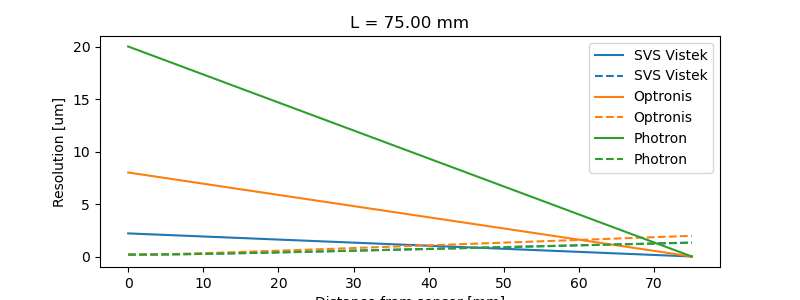

The lower L so that the entire sensor is illuminated is :  [48.63466667 22.77333333 34.13333333] mm. For the  ['SVS Vistek', 'Optronis', 'Photron'] , respectively.
In Fig. 2, we show only source-camera distances that obtain full illumination of the sensor.
Fig. 2(a): Optimal distances for each camera at different possible distances source-camera (solid). Dashed lines show the limits at which the resolution is  50 % higher than the optimum.
Fig. 2(b): Same information but as a percentage of the total source-camera distances.
Fig. 2(c): Optimum resolution for each camera at different possible distances source-camera.


<IPython.core.display.Javascript object>


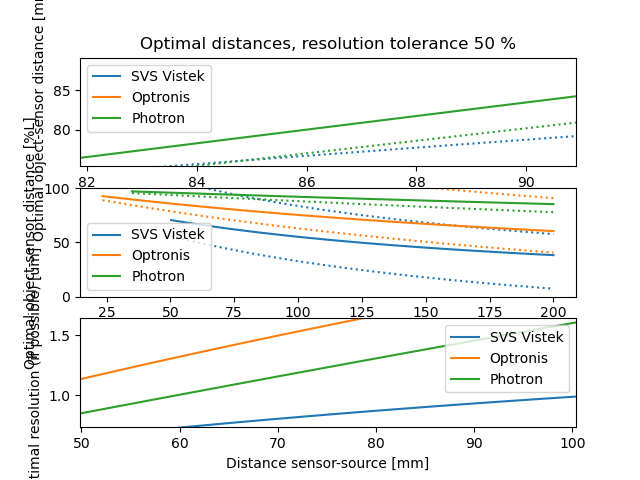

In [6]:
import matplotlib.pyplot as plt
%matplotlib notebook
wavelength = 355e-9 # 532e-9  # 
# SVS Vistek, Optronis, Photron
M = np.array([13264, 1708, 1024])
N = np.array([9176, 1696, 1024])
p = np.array([2.2e-6, 8e-6, 20e-6])
# Geometrical aspects
L = 75e-3
zs = np.linspace(0,L,1000)
# Resolution due to effective pixel
rp = p[:,np.newaxis]/L*(L-zs)
# Resolution due to NA
min_dim = np.minimum(M,N) * p
NA = min_dim[:,np.newaxis]/2/(np.sqrt(min_dim[:,np.newaxis]**2/4+zs**2))
rNA = wavelength/2/NA                                    
# Plot 1
labels = ['SVS Vistek', 'Optronis', 'Photron']
colors = ['tab:blue', 'tab:orange', 'tab:green']
print('Resolution due to effective pixel (geometrical magnification) in solid, and resolution due to NA dashed.')
fig, ax = plt.subplots(figsize=(8,3))
for y1, y2, label,col in zip(rp,rNA,labels,colors):
    ax.plot(zs/1e-3, y1/1e-6, label=label,color=col)
    ax.plot(zs/1e-3, y2/1e-6,'--',label=label,color=col)
ax.set_ylabel("Resolution [um]")
ax.set_xlabel("Distance from sensor [mm]")
ax.set_title(f'L = {L/1e-3:.2f} mm')
ax.legend()

# Lower limit of L
NAillu = 0.3  # 0.5
# Recommended minimum distance
Ds = np.vstack((M*p, N*p))
L_min = np.max(Ds, axis=0) / 2 / NAillu
print("The lower L so that the entire sensor is illuminated is : ", L_min/1e-3, "mm. For the ", labels, ", respectively.")
# Optimal object-sensor distance and resolution for different L and camera. No approximations.
nL = 100
Ls = np.linspace(10e-3, 200e-3, nL)
"""
z_opt = np.zeros((3, nL))
r_opt = np.zeros_like(z_opt)
options = {'eps': 1e-12}
for kl in range(nL):
    for kc in range(3):
        z0 = np.array([Ls[kl]/2])
        args = (p[kc], Ls[kl], wavelength, min_dim[kc])
        res = sc_opti.minimize(optimum_z_condition, z0, args, 'L-BFGS-B', bounds=((0, Ls[kl]),), tol=1e-12,
                               options=options)
        z_opt[kc, kl] = res.x[0]
        r_opt[kc, kl] = res.fun[0]
"""
min_dim = min_dim[:, np.newaxis]
p = p[:, np.newaxis]
# z_opt_approx = Ls - Ls ** 2 * wavelength / min_dim / p
# r_opt_approx = Ls * wavelength / min_dim
term_1 = min_dim**2 * p**2 / Ls
z_opt = (2 * term_1 - wavelength * min_dim * np.sqrt(term_1/Ls + 4 * p ** 2 - wavelength ** 2)) / (
        2 * term_1/Ls - 2 * wavelength ** 2)
mag_opt = Ls / (Ls - z_opt)
r_opt = p / mag_opt
# +- tol% of resolution
tolerance = 50  # %
r_max = r_opt * (1 + tolerance / 100)
# Reaching resolution tolerance at smaller object-sensor distance due to less magnification
d_below = Ls - Ls * r_max / p
# Reaching resolution tolerance at higher object-sensor distance due to less NA
d_above = np.sqrt((r_max * min_dim / wavelength) ** 2 - min_dim ** 2 / 4)
# Plot 2
print("In Fig. 2, we show only source-camera distances that obtain full illumination of the sensor.")
print("Fig. 2(a): Optimal distances for each camera at different possible distances source-camera (solid). Dashed "
      "lines show the limits at which the resolution is ", tolerance, "% higher than the optimum.")
print("Fig. 2(b): Same information but as a percentage of the total source-camera distances.")
print("Fig. 2(c): Optimum resolution for each camera at different possible distances source-camera.")
fig2, axs2 = plt.subplots(3, 1)
for minL, y1, y2, y1_below, y1_above, label, col in zip(L_min, z_opt, r_opt, d_below, d_above, labels, colors):
    axs2[0].plot(Ls[Ls > minL] / 1e-3, y1[Ls > minL] / 1e-3, label=label, color=col)
    axs2[0].plot(Ls[Ls > minL] / 1e-3, y1_below[Ls > minL] / 1e-3, ':', color=col)
    axs2[0].plot(Ls[Ls > minL] / 1e-3, y1_above[Ls > minL] / 1e-3, ':', color=col)
    axs2[1].plot(Ls[Ls > minL] / 1e-3, y1[Ls > minL] / Ls[Ls > minL] * 100, label=label, color=col)
    axs2[1].plot(Ls[Ls > minL] / 1e-3, y1_below[Ls > minL] / Ls[Ls > minL] * 100, ':', color=col)
    axs2[1].plot(Ls[Ls > minL] / 1e-3, y1_above[Ls > minL] / Ls[Ls > minL] * 100, ':', color=col)
    axs2[2].plot(Ls[Ls > minL] / 1e-3, y2[Ls > minL] / 1e-6, label=label, color=col)
axs2[0].set_ylim([0, axs2[0].get_ylim()[1]])
axs2[1].set_ylim([0, 100])
axs2[0].set_ylabel("Optimal object-sensor distance [mm]")
axs2[1].set_ylabel("Optimal object-sensor distance [%L]")
axs2[2].set_ylabel("Optimal resolution (if possible) [um]")
for an_axis in axs2:
    an_axis.set_xlabel("Distance sensor-source [mm]")
axs2[0].set_title(f'Optimal distances, resolution tolerance {tolerance} %')
for axx in axs2:
    axx.legend()

## 2.3 Axial resolution

2015 - Practical algorithms for simulation and reconstruction of digital in-line holograms

The axial resolution (z-axis) is $\delta_z = \frac{\lambda}{\mbox{NA}^2}$.

In the case of using a spherical wave, the reconstruction is done with a planar wave at different $z$ positions. Being $L$ the distance from the sensor to the source, $z'$ the distance from the sensor to the plane and $D$ the largest dimension in the sensor:
$$z=\frac{z'L}{L-z'}.$$

So, with $\mbox{NA} = \sin\left[\arctan\left(\frac{D}{2z}\right)\right]$, the axial resolution is found.

In [4]:
# Maths for DIH with plane wave
import numpy as np

wave = 355e-9
dx = 2.2e-6
M = 1
N = 9176

dp = dx/M
D = N*dp
zmax = N*dp**2/wave
print(f"Max z with resolution given by pixel size and magnification: {zmax/1e-3:.2f} mm.")
print(f"Check that zmax >> {D/2/1e-3:.2f} mm.")
zs = np.array([0.5, 1.0, 1.5])*zmax
NAs = D/2/np.sqrt((D/2)**2 + zs**2)
dzs = wave/NAs**2
dna = wave /2/ NAs
print(f"Axial resolutions at [0.5, 1, 1.5]zmax : {dzs}")
print(f"Resolution due to diffraction limit at [0.5, 1, 1.5]zmax : {dna}")

Max z with resolution given by pixel size and magnification: 125.10 mm.
Check that zmax >> 10.09 mm.
Axial resolutions at [0.5, 1, 1.5]zmax : [1.39888028e-05 5.48902113e-05 1.23059225e-04]
Resolution due to diffraction limit at [0.5, 1, 1.5]zmax : [1.11422899e-06 2.20714890e-06 3.30477023e-06]


In [5]:
print(M, p)
D = M*p
L = 80e-3
zp = np.linspace(.05, .95,200)*L
zp = zp[:, np.newaxis]
z = zp*L/(L-zp)
NA = np.sin(np.arctan(D/2/z))
delta_z = wavelength / NA**2
fig, ax = plt.subplots()
ax.semilogy(zp, delta_z)
ax.set_xlabel(f'z (real, spherical illumination L = {L/1e-3:.1f} mm)')
ax.set_ylabel('Axial resolution [m]')
ax.grid()
ax.legend(labels)

1 [[2.2e-06]
 [8.0e-06]
 [2.0e-05]]


ValueError: operands could not be broadcast together with shapes (3,1) (200,1) 

Maybe it is convenient to acquire images with lower $L$ when trying to detect properly with $z \approx L$.

#### Sampling z with constant step-to-resolution ratio

When sampling from $z_0$ to $z_N$ with $N+1$ points ($N$ steps) it is interesting to have always the same step-to-resolution ratio. So, $z_0 + \sum \Delta_{zi} = z_N$, and $\Delta_{zi} = K \delta_{zi}$. This is a nonlinear equation that can be solved using a nonlinear solver. See sample_z_sph.m

# 3. Model for calibration based on reconstructed distances and scaling between those distances

- $L$: source–sensor distance
- $z$ : effective object–sensor distance
- $d$ : object-source distance
- $m$ : $L/(L-z)$ magnification : $L/d$
- $z^r$ : reconstruction distance for $z$ : $z = z^r L / (L + z^r)$ or $z^r = z m$
- $s_{ij}$ : scale between planes with $z_i$ and $z_j$

So,
$$m_2 / m_1 = s_{12}$$
$$(L-z_1) / (L-z_2) = s_{12}$$
$$\frac{L - \frac{z^r_1 L}{L + z^r_1}}{L - \frac{z^r_2 L}{L + z^r_2}} = s_{12}$$
$$\frac{L^2}{L + z^r_1} / \frac{L^2}{L + z^r_2} = s_{12}$$
$$\frac{L + z^r_2}{L + z^r_1} = s_{12}$$
$$L+z^r_2 = s_{12}(L+z^r_1)$$
$$(1-s_{12}) L = s_{12}z^r_1 - z^r_2$$

Solve by using Least squares error method.

# 4. Lensfree DIH (Gabor)
A focusing lens is used to generate a Gaussian beam that is approximately a "spherical" wavefront. The whole aperture of the lens has to be illuminated so that its NA determines how much of the sensor is covered when it is placed at a particular source-to-sensor distance. The radius of the illumination beam has to be 1.1 times the diagonal of the camera $d$. This would mean different NA requirements depending on the desired source-to-sensor distance.
$$NA = n \sin \theta,$$
with $\theta = \arctan(\frac{1.1d}{2z})$.

The minimum source-to-sensor distance for cameras [SVS Vistek, Photron, Optronis] for a lens with NA = 0.5 are [[33.79923946 27.58810526 18.35714048]]


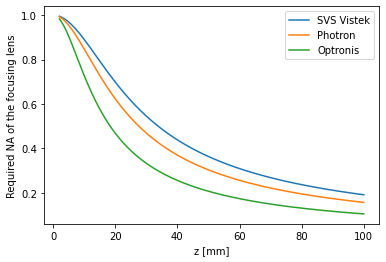

In [5]:
import numpy as np
import matplotlib.pyplot as plt

z = np.linspace(2,100,1000) # mm
ds = np.atleast_2d(np.array([35.48, 28.96, 19.27])) # mm. [SVS Vistek, Photron, Optronis]
NA = np.sin(np.arctan(1.1*ds/2/z[:,np.newaxis]))
fig, ax = plt.subplots(1,1)
ax.plot(z,NA)
ax.set_xlabel('z [mm]')
ax.set_ylabel('Required NA of the focusing lens')
ax.legend(['SVS Vistek', 'Photron', 'Optronis'])

Test_NA = 0.5
min_zs = 1.1/2*ds / np.tan(np.arcsin(Test_NA))
print("The minimum source-to-sensor distance for cameras [SVS Vistek, Photron, Optronis] for a lens with NA = {} are {}".format(Test_NA,min_zs))

If NA needs to be >0.4, we should use Thorlabs N20X-PF for 355 nm (882£) if using an MO. Or an aspheric lens C240TMD-A NA=0.5 with WD=4.8 mm, A240TM-A in glass D-LAK6 (67£).
https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=3810
Edmund Optics has UV aspheric lenses in Fused Silica. (300£) https://www.edmundoptics.com/p/125mm-dia-050-na-uv-vis-coated-uv-fused-silica-aspheric-lens/30259/ or MO in 880£ 86-819

## 4.1 Focusing of a laser beam to a small spot
A laser beam, with radius $y_1$ and divergence $\theta_1$ is focused by a lens of focal length $f$. The output angle is $\theta_2 = y_1/f$. The optical invariant forces $y_2 = \theta_1 f$, because the product of radius and divergence angle must be constant.

Using diffraction limited formula: $r_{focused} = \lambda f / r_{in}$. But it's also used the Airy formula $r_{focused} = 1.22 \lambda f / r_{in}$ 

The diameter of the pinhole in a spatial filter arrangement should be 30% more than the diameter of the focused beam.

If an MO not infinity corrected is used, the $f$ is not given but instead magnification $M$ and tube lens length $L$ (160mm or 210mm). So $f=\frac{L}{M}$. The minimum radius is obtained for the diameter of the input.

https://www.edmundoptics.eu/knowledge-center/application-notes/lasers/beam-expanders/
The spatial filter has a magnification of the beam that is $M=\frac{f_2}{f_1}=\frac{40 \mm}{15.29 \mm}$, being $f_2$ the focal length of the collimation lens. $M=r_{out}/r_{in}$, and $M=\theta_{in}/\theta_{out}$ for divergence angle in beam expanders.

In [2]:
wavelength = 355e-9
r_laser = 0.3e-3 /2 # FTSS355-Q4
theta_laser = 4e-3 # FTSS355-Q4
f1_filter = 4.51e-3 # 15.29e-3
f2_filter = 100e-3 # 40e-3
r_focus = theta_laser*r_laser
r_focus_dl = 1.22* wavelength * f1_filter / r_laser  # Focused beam diameter where pinhole goes
ph = 40e-6 /2
print("Pinhole has radius of {} um, but the radius of the focused beam is {} um by ray optics and {} um by diffraction limited. The pinhole should be around {} um.".format(ph*1e6,r_focus*1e6,r_focus_dl*1e6,r_focus_dl*1e6*1.3))
theta_focused = r_laser / f1_filter
r_filtered = theta_focused * f2_filter
theta_filtered = ph/f2_filter
print("The filtered output has radius {} um, and angle {} mrad".format(r_filtered*1e6, theta_filtered*1e3))
M = f2_filter / f1_filter
print("Using magnification M={} and disregarding the pinhole. The filtered output has radius {} um, and angle {} mrad".format(M,r_laser*M*1e6, theta_laser/M*1e3))
f_source = 12.5e-3
r_source = theta_filtered * f_source
print("The source has radius {} um".format(r_source*1e6))
print("Diffraction limited: The source has radius {} um".format(wavelength*f_source/r_filtered*1e6))

Pinhole has radius of 20.0 um, but the radius of the focused beam is 0.6 um by ray optics and 13.021873333333334 um by diffraction limited. The pinhole should be around 16.928435333333333 um.
The filtered output has radius 3325.9423503325943 um, and angle 0.2 mrad
Using magnification M=22.172949002217294 and disregarding the pinhole. The filtered output has radius 3325.942350332594 um, and angle 0.18040000000000003 mrad
The source has radius 2.5 um
Diffraction limited: The source has radius 1.3342083333333334 um


#### Using Aspheric lens with collimated wavefront at the input

Results obtained by the diffraction limit formula for a given NA and $f$.

In [ ]:
NA = 0.5
f_asph = 12.5  # mm
r_in = np.tan(np.arcsin(NA))*f_asph
r_foc = 1.22 * wavelength * f_asph / r_in
print("The radius of the focused beam using a lens with input radius {:.2f} mm and f = {} mm, is {:.2f} um".format(r_in, f_asph, r_foc/1e-6))
pulse_energy = 80 # uJ
pulse_energy_density_focus = pulse_energy / (np.pi*r_foc**2) / 1e4 / 1e6 # J/cm2
print("The pulse energy density at the focus point is {:.2f} J/cm2".format(pulse_energy_density_focus))

## 4.2 Spatial filter calculations for GEM532

Laser GEM532 specs:
- beam diameter : 0.9 mm
- divergence < 0.8 mrad
- polarization direction : horizontal
- coherence length: 1 cm
- operating temperature: 15-40

Set-up: aspheric lens with convex shape towards input, pinhole, collimating lens with convex towards output.

Diameter of focused beam: $d_f = \frac{4 \lambda f_1}{\pi D}$, where $f_1$ is the focal length of the aspheric lens and $D$ is the beam diameter of the laser.

The output diameter is $d_o = \frac{f_2}{f_1}D$.

The SLM at the output has dimensions 17.6 x 10.7 mm.

In [1]:
import numpy as np

wavel = 532e-9
f1 = 5.5e-3
beam_diam = .9e-3
M2 = 1   # Beam quality M^2 
f2 = 125e-3
diag_SLM = np.sqrt(17.6e-3**2 + 10.7e-3**2)

beam_diam_foc = 4*M2*wavel*f1/np.pi/beam_diam
print(f'Diameter of focused beam with beam quality M^2=1 is {beam_diam_foc/1e-6:.2f} um. The pinhole diameter should be {beam_diam_foc*1.3/1e-6:.2f} um.')
output_diam = f2/f1*beam_diam
print(f'The output diameter is {output_diam/1e-3:.2f} mm. The minimum output diameter (given by SLM) is {diag_SLM/1e-3:.2f} mm.')

Diameter of focused beam with beam quality M^2=1 is 4.14 um. The pinhole diameter should be 5.38 um.
The output diameter is 20.45 mm. The minimum output diameter (given by SLM) is 20.60 mm.


Required components:
- [Thorlabs ER3-P4](https://www.thorlabs.com/thorproduct.cfm?partnumber=ER3-P4) Cage Assembly Rod, 3" Long, Ø6 mm, 4 Pack £18.79 #1 *PO 5*
- [Thorlabs SM1Z](https://www.thorlabs.com/thorproduct.cfm?partnumber=SM1Z) Z-Axis Translation Mount, 30 mm Cage Compatible £149.57 #1 *PO 5*
- [Thorlabs SM1A3](https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=1524&pn=SM1A3) Adapter with External SM1 Threads and Internal RMS Threads £13.46 #1 *PO 5*
- [Thorlabs E09RMS](https://www.thorlabs.com/thorproduct.cfm?partnumber=E09RMS) Extended RMS to M9 x 0.5 Adapter £25.78 #1 *PO 5*
- [Thorlabs C105TMD-A](https://www.thorlabs.com/thorproduct.cfm?partnumber=C105TMD-A) f = 5.5 mm, NA = 0.6, Mounted Aspheric Lens, ARC: 350 - 700 nm £96.71 #1 *PO 5*
- [Thorlabs ST1XY-S/M](https://www.thorlabs.com/thorproduct.cfm?partnumber=ST1XY-S/M) XY Translator with Micrometer Drives, Metric £291.28 #1 *PO 5*
- [Thorlabs P5W](https://www.thorlabs.com/thorproduct.cfm?partnumber=P5W) Ø1" Mounted Pinhole, 5 ± 1 µm Pinhole Diameter, Tungsten £87.63 #1 *PO 5*
- [Thorlabs LA1986-A](https://www.thorlabs.com/thorproduct.cfm?partnumber=LA1986-A)	N-BK7 Plano-Convex Lens, Ø1", f = 125 mm, AR Coating: 350 - 700 nm £24.41 #1 *PO 5*
- [Thorlabs CP6T](https://www.thorlabs.com/thorproduct.cfm?partnumber=CP6T) SM1-Threaded 30 mm Cage Plate, 6.0 mm Thick £14.78 #1 *PO 5*
- [Thorlabs C30L24](https://www.thorlabs.com/thorproduct.cfm?partnumber=C30L24) 30 mm Cage System Cover, 24" Long, Pack of 4 £21.83 #1 *PO 5*
- [Thorlabs ER6-P4](https://www.thorlabs.com/thorproduct.cfm?partnumber=ER2-P4) Cage Assembly Rod, 6" Long, Ø6 mm, 4 Pack £24.64 #1 *PO 5*
- [Thorlabs DCP1](https://www.thorlabs.com/thorproduct.cfm?partnumber=DCP1) Drop-In 30 mm Cage Mount, Flexure Lock, SM1 Threaded, 0.40" Thick, 2 Retaining Rings £16.98 #4 *PO 5*
- Set of lenses : N-BK7 Bi-Convex Lens, Ø1", ARC: 350-700nm
    - f = 50 mm [Thorlabs LB1471-A](https://www.thorlabs.com/thorproduct.cfm?partnumber=LB1471-A) £26.76 #1 *PO 5*
    - f = 100 mm [Thorlabs LB1676-A](https://www.thorlabs.com/thorproduct.cfm?partnumber=LB1676-A) £25.78 #1 *PO 5*
    - f = 175 mm [Thorlabs LB1294-A](https://www.thorlabs.com/thorproduct.cfm?partnumber=LB1294-A) £25 #1 *PO 5*
    - f = 250 mm [Thorlabs LB1056-A](https://www.thorlabs.com/thorproduct.cfm?partnumber=LB1056-A) £24.79 #1 *PO 5*
- [Thorlabs FMP1/M](https://www.thorlabs.com/thorproduct.cfm?partnumber=FMP1/M) Fixed Ø1" Mirror Mount, M4 Tap £12.45 #1 *PO 5*
- [Thorlabs PF10-03-P01](https://www.thorlabs.com/thorproduct.cfm?partnumber=PF10-03-P01) Ø1" Protected Silver Mirror *(Available)*
- [Thorlabs BBE1-E02](https://www.thorlabs.com/thorproduct.cfm?partnumber=BBE1-E02) 1" Broadband Dielectric Elliptical Mirror, 400 - 750 nm £73.82 # 2 *(#1 for now)*  *PO 5*
- [Thorlabs KCB1EC/M](https://www.thorlabs.com/thorproduct.cfm?partnumber=KCB1EC/M) Right-Angle Kinematic Elliptical Mirror Mount with Smooth Cage Rod Bores, 30 mm Cage System and SM1 Compatible, M4 and M6 Mounting Holes £151.37 # 2 *(#1 for now)* *PO 5*
- [Thorlabs SM1D12D](https://www.thorlabs.com/thorproduct.cfm?partnumber=SM1D12D) SM1 Ring-Actuated Iris Diaphragm (Ø0.8 - Ø12 mm) £51.76 #1 *PO 5*
- [Thorlabs CXY1](https://www.thorlabs.com/thorproduct.cfm?partnumber=CXY1) 30 mm Cage System, XY Translating Lens Mount for Ø1" Optics *(Available)*
- Plate for lens before focusing to the sample. 
- [Thorlabs LCP05/M](https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=3517&pn=LCP05#3517) 60 mm Cage-Compatible Mount for 50 mm Square Filters Up to 4 mm Thick, M4 Tap £70.40 or [Thorlabs CYLCP/M](https://www.thorlabs.com/thorproduct.cfm?partnumber=CYLCP/M) 60 mm Cage Mount for Cylindrical Lenses, M4 Tap £76.91 *(Available)*

Not required yet:
- [Thorlabs CP30](https://www.thorlabs.com/thorproduct.cfm?partnumber=CP30) 30 mm to 30 mm Cage System Right-Angle Adapter £39.79
- [Thorlabs CP360R](https://www.thorlabs.com/thorproduct.cfm?partnumber=CP360R) Pivoting, Quick-Release, Ø1" Optic Mount for 30 mm Cage System £76.10
- [Thorlabs C6W](https://www.thorlabs.com/thorproduct.cfm?partnumber=C6W) 30 mm Cage Cube, Ø6 mm Through Holes £50.72 *Using a cube is not good powerwise*
- [Thorlabs B3C/M](https://www.thorlabs.com/thorproduct.cfm?partnumber=B3C/M) Fixed Cage Cube Platform for C4W/C6W, Metric £19.81
- [Thorlabs C6WA/M](https://www.thorlabs.com/thorproduct.cfm?partnumber=C6WA/M) C6W Platform Adapter Kit, Metric £34.29
- [Thorlabs B1C/M](https://www.thorlabs.com/thorproduct.cfm?partnumber=B1C/M) Blank Cover Plate, Metric £14.93	
- [Thorlabs BS013](https://www.thorlabs.com/thorproduct.cfm?partnumber=BS013) 50:50 Non-Polarizing Beamsplitter Cube, 400 - 700 nm, 1" £168.81
- [Thorlabs CCM1-BS013/M](https://www.thorlabs.com/thorproduct.cfm?partnumber=CCM1-BS013/M) Customer Inspired! 30 mm Cage Cube-Mounted Non-Polarizing Beamsplitter, 400 - 700 nm, M4 Tap £222.38

Around 45 cm from SLM to centre of sampled volume.

Available aspherics: 15.29 (LED), 4.51 (Spatial filter), 12.5 (divergent source) 10/3/2021

The heatsink of the laser puts the output beam into a [Thorlabs PAF-X-11-A](https://www.thorlabs.com/thorproduct.cfm?partnumber=PAF-X-11-A&pn=PAF-X-11-A#11945) FiberPort, FC/APC, f=11.0 mm, 350 - 700 nm, Ø1.80 mm Waist. A fiber [Thorlabs M42L01](https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=5794&pn=M42L01) Ø50 µm, 0.22 NA, Low OH, FC/PC-FC/PC Fiber Patch Cable, 1 m, goes then to a [Thorlabs PAF-X-2-A](https://www.thorlabs.com/thorproduct.cfm?partnumber=PAF-X-2-A&pn=PAF-X-2-A#ad-image-0) FiberPort, FC/PC & FC/APC, f=2.0 mm, 350 - 700 nm, Ø0.33 mm Waist, that is mounted in a [Thorlabs CP08FP/M](https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=2958&pn=CP08FP/M) FiberPort Adapter for 30 mm Cage System, Enhanced Clamping. A [Thorlabs CFC-2X-A](https://www.thorlabs.com/thorproduct.cfm?partnumber=CFC-2X-A&pn=CFC-2X-A#3154) Adj. FC/PC and FC/APC Collimator, f = 2.0 mm, ARC: 350-700 nm is available for using an adapter (not available) to place in a SM1 tube.

Damage threshold:
- Air/silica interface : 1 MW/cm<sup>2</sup>·area<sub>eff</sub> = MAX PWR

The effective area in single mode fibers is calculated as $\pi (\frac{\mbox{MFD}}{2})^2$, where MFD is the mode field diameter. In multimode fibers, the core diameter is used instead of MFD.

The multi-mode fiber will probably unpolarise the beam. One way of using unpolarised beams in an SLM is by using a PBS, mirror and 1/2-waveplate. But this needs a second BS to direct the returning beam back to the camera.

In [ ]:
import numpy as np
# Maximum power allowed in fiber M42L01
max_pow = 1e6 * np.pi * (.005/2)**2
print(f'Maximum allowed power in the fiber is {max_pow:.2f} W.')
# A beam coming from the fiber M42L01 goes into the FiberPort PAF-X-2-A
# Let's assume that a 50 um 0.22 NA beam comes out from the fiber, 
wavel = 532e-9
f_FP = 2e-3
fiber_diam = 50e-6
beam_diam_FP = 4*wavel*f_FP/np.pi/fiber_diam
print(f'Diameter of output beam is {beam_diam_FP/1e-6:.2f} um. THIS IS NOT CORRECT')
# It does not make sense. Let's assume that the lens collimates a beam with width equal to the fiber diameter and coming out with the fiber NA.
NA_fiber = 0.22
theta_fiber = np.arcsin(NA_fiber)
beam_diam_FP = 2 * f_FP * np.tan(theta_fiber)
print(f'Geometrically, the diameter of the output beam of the FiberPort is {beam_diam_FP/1e-6:.2f} um.')
divergence = fiber_diam / f_FP
print(f'The divergence angle of the collimated beam is {divergence/1e-3:.2f} mrad.')
# This is the value that needs to be used for the calculation of the pinhole.

print('###')
beam_splitter_diag = 25.4e-3 * np.sqrt(2)
print(f'Calculations of required optics for dealing with a wide beam.\nBear in mind that optics are usually 1", 2", elliptical/1" beam splitter with axis/diagonal {beam_splitter_diag/1e-3:.2f} mm.')
# A 21 mm wide laser beam that reflects on a mirror at 45° needs a surface with diameter:
wide_in = 21e-3
angle = 46
tilted_width = wide_in / np.cos(angle*np.pi/180)
print(f'A {wide_in/1e-3:.2f} mm wide laser beam that reflects on a mirror at {angle:.2f}° needs a surface with diameter {tilted_width/1e-3:.2f} mm.')
tilted_width_2mirrors = wide_in / np.cos(angle*np.pi/180/2)
print(f'Using two mirrors, the required width is {tilted_width_2mirrors/1e-3:.2f} mm.')

print('###')
# Polarization of beam at the SLM must be 45°. The laser is horizontally polarized. 
# A half-wave plate at angle phi from horizontal direction obtains:
phi = -np.pi/8
aligned_comp = np.cos(phi) # Component of input that is aligned to the non-retarding axis
ret_comp = np.sin(phi)
# The output phasor is the sum of aligned_comp*exp(i phi) + ret_comp*exp(i (phi+pi/2))
phasor_out = aligned_comp*np.exp(1j*phi) + ret_comp*np.exp(1j*(phi+np.pi/2))
phase_out = np.angle(phasor_out)
print(f'If the half-wave plate is in an angle of {phi/np.pi*180:.2f}°, then the output angle with respect to the input is {phase_out/np.pi*180:.2f}°.')

## 4.3 Using windows
### About the diameter of the output window
Sapphire windows can be bought from Thorlabs or Edmund Optics. Thorlabs only has 1/2" (3 mm) and 1" (5 mm). Edmund offers also in diameters of 30, 31.75, 35, 38.1 mm. If the source is placed far away from the sensor, the angle of the beam arriving to the sensor with diameter $D$ is smaller, giving a wider beam where the window is placed. The distance from source to sensor $z$ can be as much as 8 cm. Assuming that there is a distance $z_w = 1.2 \cm$ between the window and the sensor, the minimum size of the window $D_w$ should satisfy $\frac{D}{z} = \frac{D_w}{z-z_w}$.

In [ ]:
z = 8e-2  # m
D = 35.48e-3  # m
zw = 1.2e-2  # m
Dw = D/z*(z-zw)
print("The minimum size of the window to cover the entire sensor is {:.2f} mm".format(Dw*1000))
# Distance to make it work having a fixed Dw: (z-zw)D = z Dw -> z(D-Dw) = zw D -> z = zw D / (D-Dw)
Dw = 25.4e-3  # m
print("Maximum distance source/sensor when a \u2300{}mm window is {:.1f} mm from the sensor is {:.2f} mm.".format(Dw*1e3, zw*1000, 1e3*zw*D/(D-Dw)))

### Effects of the windows
The effect of a window with thickness $d_w$ to the spherical wavefront is analysed in terms of the geometrical ray with the largest angle $\theta_i$ impinging to the window. The output angle is equal to the output angle, but the equivalent distance that the wavefront should travel in free space to get the same effect as going through the window is $$d'=\frac{d_w \cos\theta_i}{n\sqrt{1-\left(\frac{\sin\theta_i}{n}\right)^2}} = \frac{d_w}{\tan\theta_i}\Phi(\theta_i,n); \Phi(\theta_i,n) = \frac{\sin\theta_i}{\sqrt{n^2-\sin^2\theta_i}}$$
The lateral distance from the input spot at the output is $w = d_w \Phi(\theta_i,n)$.

If $\sin \theta_i = \theta_i$, 
$$d'=\frac{d_w}{\sqrt{n^2-\theta_i^2}}$$

In [ ]:
dw = 1e-3   # thickness window
n = 1.79   # 355 nm, 1.76 at higher wavelengths
locw = 5e-3  # Location of the window from the spherical source
L_source_sensor = 6e-2  # This distance, and the size of the sensor, are used to get the angles of interest
sensor_diagonal = 35.48e-3
max_angle = np.arctan(sensor_diagonal/2/L_source_sensor)
print("Max angle is {:.2f} rad ({:.2f} deg).".format(max_angle, max_angle*180/np.pi))
total_eq_distance = locw + dw/np.sqrt(n**2-max_angle**2)
output_rad = np.tan(max_angle)*total_eq_distance
print("The necessary diameter of the window is {:.2f} mm.".format(output_rad*2*1e3))
thetas = np.linspace(0,max_angle,100)
ys = locw * np.tan(thetas)  # height in window
# Angles of propagation inside the window
thetas_in = np.arcsin(np.sin(thetas)/n)
# Locations on the output of the window
ys_out = ys + dw*np.tan(thetas_in)
# Locations on the output if there wasn't window
ys_out_nw = (locw + dw)*np.tan(thetas)
# New source location
new_sources = np.hstack([0, ys_out[1:] / np.tan(thetas[1:])])

fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(ys*1e3,ys_out*1e3,ys*1e3,ys_out_nw*1e3)
ax[0].set_title("Height transference of the rays")
ax[0].set_xlabel("Input height of ray [mm]")
ax[0].set_ylabel("Output height of ray [mm]")
ax[1].plot(ys*1e3,ys_out/ys_out_nw)
ax[1].set_title("Height transference vs no-window")
ax[2].plot(ys[1:]*1e3,1e3*new_sources[1:])
ax[2].set_title("Equivalent position of the source [mm]")

Phi = np.sin(thetas) / n /np.sqrt(1-(np.sin(thetas)/n)**2)
effects = Phi / np.tan(thetas)   
# fig,ax = plt.subplots(1,2)
# ax[0].plot(thetas,effects)
# ax[1].plot(thetas,effects*dw)
ws = dw * Phi   # displacement of beam at the output of the window
ws_free = dw * np.tan(thetas) # displacement of beam if it was free space
fig,ax = plt.subplots(1,1)
ax.plot(thetas,ws/ws_free)
ax.set_title("Height transference vs no-window using Snell's law")

# Using ABCD matrix
v_in = np.hstack((ys, thetas))
v_out = np.zeros_like(v_in)
# for 
# ABCD = 


It is important to know the diameter of the beam after the source window for the Laser Safety calculations. If the window is placed $z=1\mm$ away from the spot, and NA=0.5, the diameter is

In [ ]:
z = 1e-3
NA = 0.5
D = 2*z/np.sqrt(1/NA**2-1)
print(D)

### Using Snell's Law in Fourier space
Snell's Law:
$$n_i \sin \theta_i = n_o \sin \theta_o$$
When a particular wavefront propagating in free space goes through a flat interface with a refractive index of $n$, each spatial frequency component of the wavefront is related to an angle of incidence, $f_i(x)=a_{\theta_i} \sin(k\sin\theta_i x)$. After the interface, this component changes to $f_o(x)=a_{\theta_o} \sin(k\sin\theta_o x) = a_{\theta_o} \sin(k/n\sin\theta_i x)$. Where the change of amplitude is calculated from the Fresnel coefficients that depend on polarization.

### Using ABCD matrix
Ray tracing under the paraxial approximation is done using the ABCD matrix formulation.
\\[ \begin{bmatrix} y_2\\ \theta_2\end{bmatrix} = \begin{bmatrix} A & B\\C & D \end{bmatrix} \begin{bmatrix} y_1\\ \theta_1\end{bmatrix} \\]
Usual matrices are:
\\[\mbox{Propagation }\begin{bmatrix} 1 & 0\\d & 1 \end{bmatrix} \mbox{, Lens with focal length } f \begin{bmatrix} 1 & -\frac{1}{f}\\0 & 1 \end{bmatrix} \mbox{, Flat interface } \begin{bmatrix} 1 & 0\\0 & \frac{n_1}{n_2} \end{bmatrix} \mbox{, Single prism } \begin{bmatrix} k & \frac{d}{nk} \\ 0 & \frac{1}{k} \end{bmatrix},\\]
\\(k = (cos{\displaystyle \psi }/cos{\displaystyle \phi })\\) is the beam expansion factor, where ${\displaystyle \phi}$ is the angle of incidence, ${\displaystyle \psi }$  is the angle of refraction, $d =$ prism path length, $n =$ refractive index of the prism material. This matrix applies for orthogonal beam exit.


## 5 Spatial filter with 3 lenses to get higher beam magnification
A third positive (biconvex) relay lens is added between typical lenses. The lens will image the focused beam to the focal point of the output lens.

If a magnification $M=\frac{d_o}{d_i}$ is seeked, and $\frac{1}{f_r}=\frac{1}{d_i}+\frac{1}{d_o}$, choosing a particular $f_r$, will get a distance from centre of the lens to the focused beam (pinhole) and the distance $d_i$ from the lens to the imaged focused beam. So,
$$d_i = \frac{M+1}{M} f_r$$
$$d_o = M d_i$$

In [ ]:
M = 1/3
f = 25
di = (M+1)/M*f
do = M*di
print("d_o = {} mm, d_i = {} mm".format(do, di))

# 6. Damage threshold of sensor

## Damage threshold

2017 - Laser-induced damage threshold of camera sensors and micro- optoelectromechanical systems

- Pulsed laser: CMOS 0.1 J/cm$^2$, CCD 0.04 J/cm$^2$
- CW: CMOS 75 kW/cm$^2$, CCD 146 kW/cm$^2$

SVS Vistek hr120MCX, Optronis CP80, Photron Mini Ax200 are CMOS.

## Direct laser

- GEM532 1W 0.9 mm diameter
- FTS355-Q4 40 uJ 0.3 mm diameter

## A neutral density filter calculation

I have an NDF with OD = 0.5 and I want another one that attenuates half of that. $T_1 = I/I_0 = 10^{-0.5}$. I want double output. $T_2 = 2 T_1 = 10^{-x}$. So, $x = 0.5 - \log_{10}2$.

In [ ]:
import numpy as np
mm = 1e-3;
uu = 1e-6;
nn = 1e-9;

# FTS355 Energy density
diameter = 0.3 * mm
pulse_energy = 40 *uu # uJ
E = pulse_energy / (np.pi * (diameter/2)**2)
print(f'{E/1e4:.2f} J/cm\u00b2')

# Gem532 Power density
diameter = 0.9 * mm
power_laser = 1 # W
P = power_laser / (np.pi * (diameter/2)**2)
print(f'{P/1e3/1e4:.2f} kW/cm\u00b2 \n----------------- \n')

# A neutral density filter calculation

print(0.5-np.log10(2))

## POs

Purchase orders (PO) Counting in DH Setups notebook too. Requisitions:

5. 1986114  Creation Date 22/03/2021


# 7. Optics for planar wavefront DIH

Cameras sensor sizes:
- Photron Fastcam Ax200 900K? : 20.48 x 20.48mm / 28.96mm (width x height / diagonal) (~APS-C) C-mount, F-mount (look for it)
- SVS Vistek hr120MCX : 29.18 x 20.19 mm / 35.48 mm (APS-H) M-58 (M-52, SM2 adapters) Thorlabs SM2 ext F-mount £76
- Optronis CP80-3M-540 : 13.57 mm x 13.68 mm / 19.27 mm C-mount, F-mount? (extra adapter)
- Chronos 1.4 : 8.45mm x 6.76mm / 10.82 mm (6.6um pixel size) CS-mount (C-mount too?)

F-mount, 44mm. M-42.

## Navitar

http://www.opticalwizard.com/

NUV-VIS are motorized. Designed for C-mount 2/3".

### Navitar 12X

Rear adapter 2X (2/3") + 12X Zoom + 2X lens attachment : WD 37 mm, Mag 2.32-28, NA 0.038-0.202, resolution 9-16 um.

### Navitar 4k 

2x rear adapter in Photron, 2.0x lens attachment. Mag 2.5 - 18. NA 0.19 (resolution 532 nm : 5-2 um resolution) FOV 12.50 - 1.78 mm.

Camera mount:
- C-mount : 3-63266 is it a problem? 
- F-mount : 3-62923
- M42     : 1-55281  or M42 to SM2
Rear adapter:
- 2x : 1-81104 	MVR20A	2.0X Resolv4K Rear Adapter, f = 320.0 mm £1,479.85
Body:
- Fixed 4K : 1-80800 
- MVR4K	7X Resolv4K Zoom Lens £2,875.13

Lower Interface:
- 90 fold: 1-81302
- lower coupler : 1-81300 (mandatory?)
- lens attachments : 1-81207 2x
Objective coupler: UltraZoom £100
- 1-81305: M26x36T (Navitar)
- 1-81306: 0.800-36 RMS
Objective (see below)

Thorlabs : Tube lens / MO
- Tube Lens, f = 200 mm, ARC: 350 - 700 nm, External SM2 Threads £375
- MO :
    - 10X Mitutoyo Plan Apochromat Objective, 436 - 656 nm, 0.28 NA, 34 mm WD £726.23
    - RMS10X	10X Olympus Plan Achromat Objective, 0.25 NA, 10.6 mm WD £293
    - N10X-PF	10X Nikon Plan Fluorite Imaging Objective, 0.3 NA, 16 mm WD £816.29

## Infinity

### InfiniTube

Ultima Tube lens for infinity corrected MOs: £1,422.70
- T mount (M42), T2 adapter (M48)
- M27 adapter required £135
    - IF objective
- optional amplifiers:
    - NTX 2X  £385
    - DL 2X (C-mount required £45)

### InfiniProbe TS-160

- InfiniProbe TS-160 PRO with Macro PRO Objective £2,686.00
    - Maximum Diameter (mm): 35
    - Mount: M42 x 0.75 (T-Mount)
    - Mag: 0X – 4X Macro 
- Micro HM Objective £537.10 : 4X – 16X Micro Configurations

NA is not so good.

### K-Series Long-Distance Microscopes

#### K1 CentriMax

Focusing from 3m to 60 mm with constant magnification. Z-depth measurements.

Use NTX 2X rear for large format.

Use MX objectives. If using MO, the magnification has to be low, and the resulting NA will be low.

#### Model K2 DistaMax

https://www.infinity-usa.com/k-series/model-k2-distamax/

- Main body : £5,096.30
- F-mount Nikon AI Series (B) - T-Mount Adapter : £41.00
- K2 Close-Focus Objective CF-4 : £627.30
    - Mag 6.1X - 4.57X
    - NA 0.204 - 0.172
- NWE Objective £598.60
    - If used alone (for inf to 675mm)
    - K2 Microscope Adapter Disc £147.60
        - RMS adapter £135.30
        
### KC
Low magnification.

- InFocus, KC VideoMax (ST) : 2,740.00 USD
- IF-4 Objective (2.29x to 2.98x; 73mm to 63mm W.D.) 360 USD
- Large Format Amplifier (LFA) 3x : 655.00 USD


## Choosing

The 532 nm laser will work with Photron and not great resolution 2 um => 10X, if $0.61\lambda/\mathrm{NA} = 2\mu m$, then NA should be at least 0.16.

1. Know the expected FOV and magnification for the different setups : frame rate to choose camera
2. Establish a decent WD for making the experiment comfortable

In [16]:
wavelength = 532e-9
pixel = 20e-6
magnification = 18
Npixels = 1024
min_NA = 0.61*wavelength/pixel * magnification
print("At least, use NA = ", f'{min_NA:.2f}')

NA = 0.27 # min_NA
resolution_MO = 1.22*wavelength/NA
half_width_sensor = Npixels/2*pixel/magnification
max_dist = half_width_sensor / NA
print(f"Maximum distance with resolution @{resolution_MO/1e-6:.2}um : ", f'{max_dist/1e-3:.2} mm')
print(f"FOV : {2*half_width_sensor/1e-3:.3f} mm")

At least, use NA =  0.29
Maximum distance with resolution @2.4um :  2.1 mm
FOV : 1.138 mm


# Is UV camera good for getting lower resolution?

Currently we can use 355nm and 532nm lasers with SVS-Vistek hr120MCX camera (rolling shutter), Optronis and Photron cameras
with resolutions 13264 x 9176, 1708 x 1696, 1024 x 1024, and pixel sizes 2.2, 8, 20 um.

The available imaging lenses are Navitar 12x for the Optronis and Navitar 4k for the Photron and SVS-Vistek (and Optronis). Navitar 12x obtains maximum NA=0.2 with magnification of 28X. NAvitar 4k obtains NA=0.12 with 11X or 0.3 with 27X.

The UV camera SVS-Vistek fxo487MXGE (200-400nm), global shutter, 2840 x 2840 px, 2.74 um, 2/3 sensor type.

Calculations at 240 nm:\
MO LMUL-10X achieves resolution 1.17 um, pixel size 0.27 um, FOV = 0.78 mm, up to a distance of 2.27 um. \
MO LMUL-20X achieves resolution 0.81 um, pixel size 0.14 um, FOV = 0.39 mm, up to a distance of 0.25 um. \
MO LMU-5X achieves resolution 2.44 um, pixel size 0.55 um, FOV = 1.56 mm, up to a distance of 41.45 um.\ 
MO LMU-20X achieves resolution 0.77 um, pixel size 0.14 um, FOV = 0.39 mm, up to a distance of 0.22 um.\
MO LMU-3X achieves resolution 3.66 um, pixel size 0.91 um, FOV = 2.59 mm, up to a distance of 261.14 um.\
MO LMU-15X achieves resolution 0.98 um, pixel size 0.18 um, FOV = 0.52 mm, up to a distance of 0.68 um.

TL is £3.5.

MO Navitar 4k achieves resolution 2.89 um, pixel size 0.44 um, FOV = 4.04 mm, up to a distance of 177.05 um.

In [8]:
import numpy as np

wavel = 355e-9
pixel = 2.2e-6
# MO = ["LMUL-10X", "LMUL-20X", "LMU-5X", "LMU-20X","LMU-3X", "LMU-15X"]
# magnification = [10, 20, 5, 20, 3, 15]
# NA = [0.25, 0.36, 0.12, 0.38, 0.08, 0.3]
MO = ["Navitar 4k"]
magnification = [5]
NA = [0.15]
Nx = 9176

for k in range(len(MO)):
    eff_pixel = pixel / magnification[k]
    FOV = Nx * eff_pixel
    resolution = 1.22 * wavel/NA[k]
    z_max = (FOV / 2)**2 * (1/NA[k]**2 - 1)    
    print(f"MO {MO[k]} achieves resolution {resolution*1e6:.2f} um, pixel size {eff_pixel*1e6:.2f} um, FOV = {FOV*1e3:.2f} mm, up to a distance of {z_max*1e6:.2f} um.")

MO Navitar 4k achieves resolution 2.89 um, pixel size 0.44 um, FOV = 4.04 mm, up to a distance of 177.05 um.
